In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
import torch
import pandas as pd 
import numpy as np
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix

In [ ]:

from preprocess import *

In [ ]:
train_link = "/content/drive/My Drive/TEPdata/experiment_1/normal_10000.csv"
test_link = "/content/drive/My Drive/TEPdata/experiment_2/TEP_multi_attack_offical.csv"
test_link = "/content/drive/My Drive/TEPdata/experiment_1/df_IDV(4).csv"
model_link = "/content/demo_model.pth"

#dc= threshold_experiment(train_link, test_link, model_link, 1,2)

In [ ]:

processor = DataProcessor(train_link, test_link, "Fault", "Unnamed: 0")
X_train = processor.X_train
y_train = processor.y_train
X_test = processor.X_test
y_test = processor.y_test
scaler = processor.scaler_function
col_names = processor.col_names



In [ ]:

!apt install libgraphviz-dev
!pip install pygraphviz


In [ ]:
pip install causalnex

In [ ]:
import warnings
from causalnex.structure import StructureModel
import networkx as nx
from IPython.display import Image
from causalnex.plots import plot_structure, NODE_STYLE, EDGE_STYLE
from causalnex.network import BayesianNetwork

warnings.filterwarnings("ignore")  # silence warnings

sm = StructureModel()
sm = nx.drawing.nx_pydot.read_dot("/content/reduced_graph.dot")

In [ ]:
dis = X_train.copy()

In [ ]:
import warnings





warnings.filterwarnings("ignore")  # silence warnings

sm = StructureModel()
sm = nx.drawing.nx_pydot.read_dot("/content/reduced_graph.dot")

sm.remove_node("\\n")


import pandas as pd

def remove_brackets(df):
    old_to_new_names = {}
    for col in df.columns:
        new_col = col.replace('(', '').replace(')', '')
        old_to_new_names[col] = new_col
    df = df.rename(columns=old_to_new_names)
    return df, old_to_new_names

X_train,dict_name = remove_brackets(X_train)
X_test,_ = remove_brackets(X_test)

sm = nx.relabel_nodes(sm, dict_name)
bn = BayesianNetwork(sm)

import pandas as pd

def remove_brackets(df):
    old_to_new_names = {}
    for col in df.columns:
        new_col = col.replace('(', '').replace(')', '')
        old_to_new_names[col] = new_col
    df = df.rename(columns=old_to_new_names)
    return df, old_to_new_names

def quantile_discretize(df):
    cols = list(df.columns)
    for col in cols:
        q = [0, 0.05, 0.2, 0.8, 0.95, 1]
        bins = df[col].quantile(q)
        labels = ["Very Low", "Low", "Normal", "High", "Very High"]
        df[col] = pd.cut(df[col], bins=bins, labels=list(bins)[:-1], include_lowest=True)

    return df

abc = quantile_discretize(X_test)

def define_discretize_variable_states(df):
    cols = list(df.columns)
    labels = ["Very Low", "Low", "Normal", "High", "Very High"]
    for col in cols:
        cutoff = sorted(list(pd.unique(df[col])))
        cutoff_dict = {cutoff[i]: labels[i] for i in range(len(cutoff))}
        #d = {val: "G" + str(i+1) for i, val in enumerate(list(pd.unique(df[col])))}
        df[col] = df[col].map(cutoff_dict)

    return df

data = define_discretize_variable_states(abc)
bn = bn.fit_node_states(data)
#bn = bn.fit_cpds(data)
bn = bn.fit_cpds(data, method="BayesianEstimator", bayes_prior="K2")



In [ ]:
from causalnex.inference import InferenceEngine

ie = InferenceEngine(bn)


In [ ]:
marginals = ie.query()


In [ ]:
check = ie.query(observations={"XMV6":"Very High"})

In [ ]:
marginals["XMV10"]

In [ ]:
marginals_short = ie.query({"XMV6": "Very High"})

In [ ]:
marginals_short.items()

In [ ]:
marginals_short["XMEAS10"]

{'High': 0.29108910891089107,
 'Low': 0.0019801980198019802,
 'Normal': 0.007920792079207921,
 'Very High': 0.697029702970297,
 'Very Low': 0.0019801980198019802}

In [ ]:

ie.do_intervention("XMV6",
                   {'Very High': 1,
                    'High': 0.0,
                    'Normal': 0.0,
                    'Low': 0.0,
                    'Very Low': 0.0})
print("distribution after do", ie.query()["XMV6"])

distribution after do {'High': 0.0, 'Low': 0.0, 'Normal': 0.0, 'Very High': 1.0, 'Very Low': 0.0}


In [ ]:
print("Marginal G1 | Short Studtyime", marginals_short["XMEAS10"])

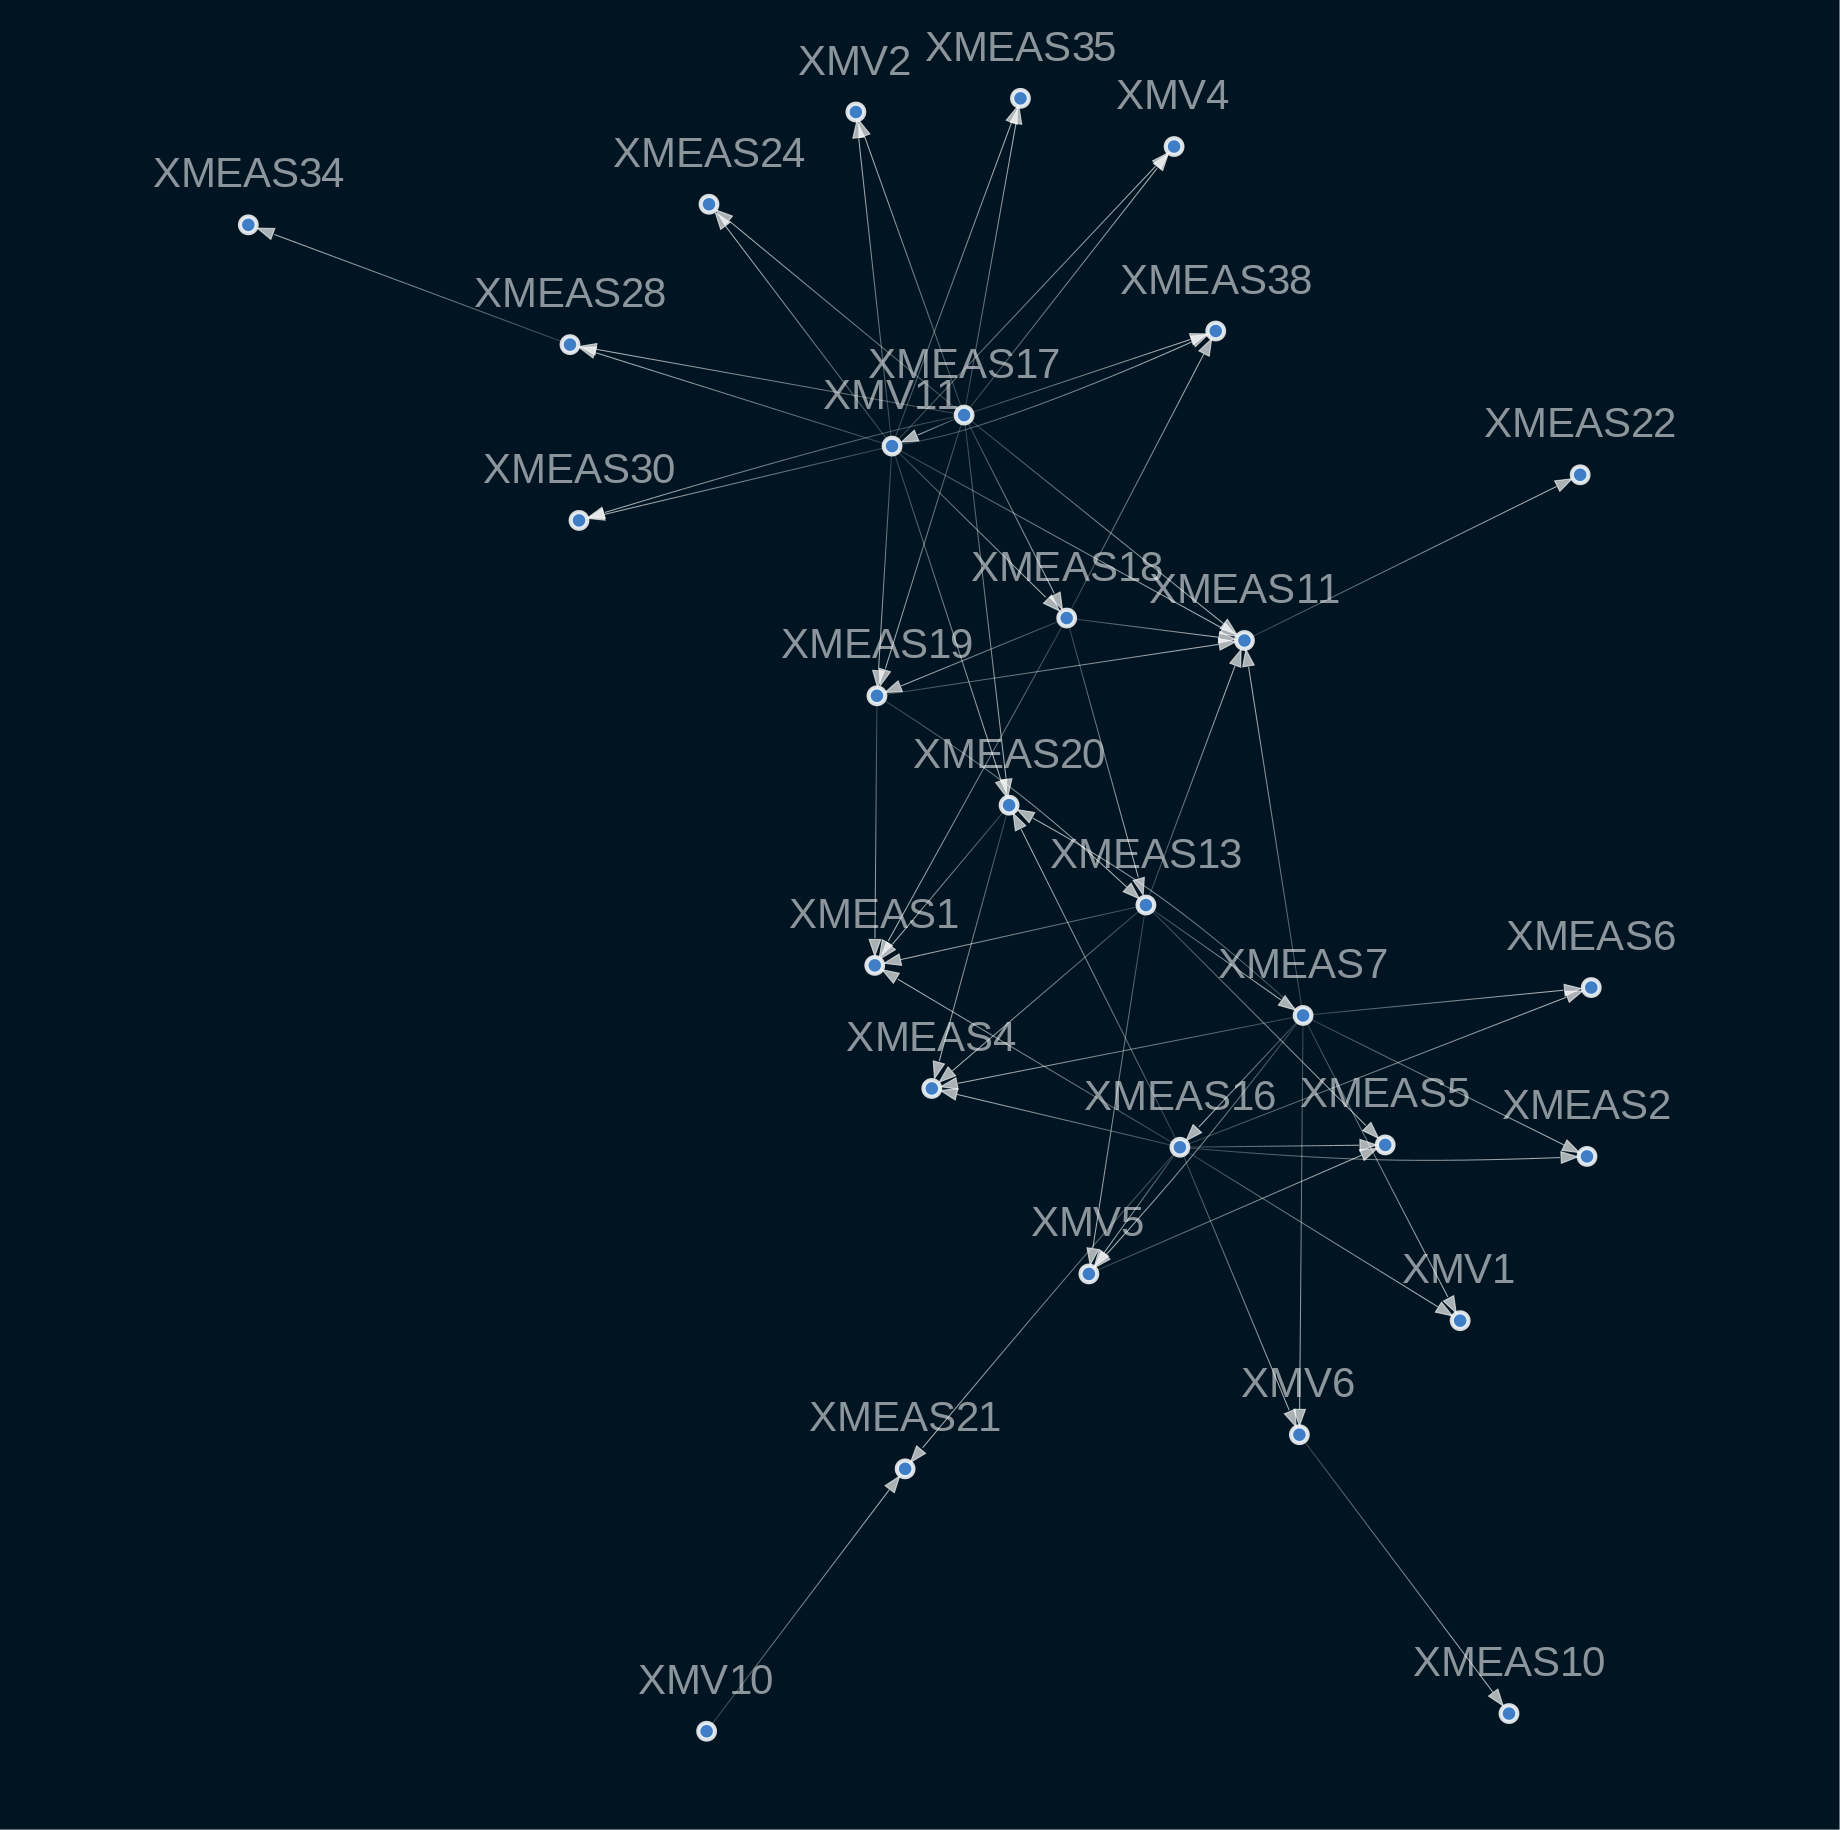

In [ ]:
from IPython.display import Image
from causalnex.plots import plot_structure, NODE_STYLE, EDGE_STYLE
from causalnex.network import BayesianNetwork
viz = plot_structure(
    sm,
    graph_attributes={"scale": "1"},
    all_node_attributes=NODE_STYLE.WEAK,
    all_edge_attributes=EDGE_STYLE.WEAK)
filename = "/content/structure_model.png"
viz.draw(filename)
Image(filename)
from IPython.display import Image, display
display(Image(filename, width=800,height = 800))

In [ ]:
pip install semopy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 22.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for semopy: filename=semopy-2.3.9-py3-none-any.whl size=1657783 sha256=a4ad6561d55c227aecab44cb28a4dfc67f63dd878210915189771bb3688cf5d2
  Stored in directory: /root/.cache/pip/wheels/13/da/5e/49e857e7074c81682fd954bc51e3564af830411ef584d7cb88
  Created wheel for sklearn: filename=sklearn-0.0.post1-py3-none-any.whl size=2935 sha256=b6bbe855990d468af65c5b35b7aec65e046595d75b6bbe26c61ee4bbe7fecd9f
  Stored in directory: /root/.cache/pip/wheels/f8/e0/3d/9d0c2020c44a519b9f02ab4fa6d2a4a996c98d79ab2f569fa1
Successfully built semopy sklearn


In [ ]:
import semopy
import numpy as np
import pandas as pd

np.random.seed(123)

N = 100
eta1 = np.random.normal(size=N)
eta2 = np.random.normal(size=N)
eta1 += 0.3 * eta2

y1 = np.random.normal(size=N, scale=0.5) + eta1
y2 = np.random.normal(size=N, scale=0.5) + 2 * eta1
y3 = np.random.normal(size=N, scale=0.5) + 3 * eta1 + eta2
y4 = np.random.normal(size=N, scale=0.5) - eta2
y5 = np.random.normal(size=N, scale=0.5) + 1.5 * eta2
x = np.random.normal(size=N)
data = pd.DataFrame([y1, y2, y3, y4, y5, x],
                    index=['y1', 'y2', 'y3', 'y4', 'y5', 'x']).T

print(semopy.efa.explore_cfa_model(X_train))

eta1 =~ XMEAS7 + XMEAS13 + XMEAS16 + XMV5 + XMEAS20 + XMEAS11 + XMEAS31 + XMEAS33 + XMEAS18 + XMEAS25 + XMEAS38 + XMV9 + XMEAS35 + XMEAS19 + XMEAS27 + XMV2 + XMEAS3 + XMEAS30 + XMEAS21 + XMEAS34 + XMEAS36 + XMEAS4 + XMEAS24 + XMEAS28 + XMEAS32 + XMEAS26
eta2 =~ XMEAS20 + XMEAS18 + XMV9 + XMEAS19 + XMV5 + XMEAS16 + XMEAS38 + XMEAS31 + XMEAS29 + XMEAS33 + XMEAS25 + XMEAS23 + XMEAS27 + XMEAS21 + XMEAS34 + XMEAS36 + XMEAS8 + XMEAS28
eta3 =~ XMEAS21 + XMV10 + XMEAS9 + XMEAS2 + XMV1 + XMEAS22 + XMEAS11 + XMEAS6
eta4 =~ XMEAS17 + XMV11
eta5 =~ XMEAS12 + XMV7
eta6 =~ XMV8 + XMEAS15
eta7 =~ XMEAS20 + XMV5 + XMEAS38 + XMEAS33 + XMEAS1 + XMV3 + XMEAS16 + XMEAS27 + XMEAS29 + XMEAS23 + XMV2 + XMEAS3 + XMEAS4 + XMEAS30 + XMEAS24 + XMEAS2 + XMV1 + XMEAS9 + XMEAS6
eta8 =~ XMEAS10 + XMV6 + XMEAS22
eta9 =~ XMEAS13 + XMV5 + XMEAS20 + XMEAS11 + XMEAS31 + XMEAS25 + XMEAS35 + XMEAS29 + XMV2 + XMEAS3 + XMV10 + XMEAS22 + XMEAS4 + XMEAS8 + XMEAS9 + XMEAS2 + XMV1 + XMEAS26 + XMEAS6 + XMEAS40 + XMEAS41
eta10 =~ 

In [ ]:
pine = semopy.efa.explore_pine_model(X_train)

1 defaultdict(<class 'set'>, {'eta1_1': ['eta1', 'eta9', 'eta3', 'eta2', 'eta10', 'eta8', 'eta7'], -1: {'eta4', 'eta6', 'eta5'}})


In [ ]:
print(pine)

eta1 =~ XMEAS7 + XMEAS13 + XMEAS16 + XMV5 + XMEAS20 + XMEAS11 + XMEAS31 + XMEAS33 + XMEAS18 + XMEAS25 + XMEAS38 + XMV9 + XMEAS35 + XMEAS19 + XMEAS27 + XMV2 + XMEAS3 + XMEAS30 + XMEAS21 + XMEAS34 + XMEAS36 + XMEAS4 + XMEAS24 + XMEAS28 + XMEAS32 + XMEAS26
eta2 =~ XMEAS20 + XMEAS18 + XMV9 + XMEAS19 + XMV5 + XMEAS16 + XMEAS38 + XMEAS31 + XMEAS29 + XMEAS33 + XMEAS25 + XMEAS23 + XMEAS27 + XMEAS21 + XMEAS34 + XMEAS36 + XMEAS8 + XMEAS28
eta3 =~ XMEAS21 + XMV10 + XMEAS9 + XMEAS2 + XMV1 + XMEAS22 + XMEAS11 + XMEAS6
eta4 =~ XMEAS17 + XMV11
eta5 =~ XMEAS12 + XMV7
eta6 =~ XMV8 + XMEAS15
eta7 =~ XMEAS20 + XMV5 + XMEAS38 + XMEAS33 + XMEAS1 + XMV3 + XMEAS16 + XMEAS27 + XMEAS29 + XMEAS23 + XMV2 + XMEAS3 + XMEAS4 + XMEAS30 + XMEAS24 + XMEAS2 + XMV1 + XMEAS9 + XMEAS6
eta8 =~ XMEAS10 + XMV6 + XMEAS22
eta9 =~ XMEAS13 + XMV5 + XMEAS20 + XMEAS11 + XMEAS31 + XMEAS25 + XMEAS35 + XMEAS29 + XMV2 + XMEAS3 + XMV10 + XMEAS22 + XMEAS4 + XMEAS8 + XMEAS9 + XMEAS2 + XMV1 + XMEAS26 + XMEAS6 + XMEAS40 + XMEAS41
eta10 =~ 

In [ ]:
cfa = semopy.efa.explore_cfa_model(X_train)

In [ ]:
mod = semopy.Model(cfa)
res = mod.fit(X_train)
print(res)

Name of objective: MLW
Optimization method: SLSQP
Optimization successful.
Optimization terminated successfully
Objective value: 5.168
Number of iterations: 1456
Params: 1.665 1.054 -0.016 -0.035 15.003 -0.026 0.011 21.150 -180.007 -262.894 -4.326 -0.454 -8.491 -2.470 -0.039 -4.850 -0.463 -0.014 -0.083 -0.975 0.161 -0.918 -0.035 -2.389 -0.040 -0.067 -0.145 -0.900 0.169 0.930 2.163 -0.850 0.170 -0.302 -0.018 -0.069 0.708 0.037 0.551 0.292 0.046 -0.047 -0.280 -0.037 -4.547 -0.012 -0.365 0.026 -0.348 0.017 16.103 0.044 23.288 -0.185 -0.026 -0.223 0.018 -0.164 -1.019 -1.257 0.071 0.104 0.339 0.048 0.052 -0.035 -0.340 -1.371 -9.083 -1.306 -0.026 -8.546 -0.887 0.043 -5.772 -0.919 0.034 -5.971 -0.438 0.180 -2.898 -0.185 -0.029 -1.235 -0.030 -0.989 0.998 1.000 -0.425 -0.424 1.055 0.136 -0.099 -0.231 0.016 2.960 0.572 0.968 0.006 0.956 0.985 0.000 0.559 0.786 0.854 0.423 0.860 0.485 0.054 0.751 0.335 0.007 0.009 0.642 0.018 0.973 0.765 0.942 0.909 0.949 0.035 0.012 0.000 0.864 0.577 0.101 0.010

In [ ]:
ins = mod.inspect()
print(ins)

        lval  op     rval  Estimate  Std. Err     z-value   p-value
0     XMEAS7   ~     eta1  1.000000         -           -         -
1    XMEAS13   ~     eta1  1.664551  0.420823    3.955462  0.000076
2    XMEAS13   ~     eta9  1.000000         -           -         -
3    XMEAS16   ~     eta1  1.054422  0.004902  215.108861       0.0
4    XMEAS16   ~     eta2 -0.016082  0.005752   -2.795796  0.005177
..       ...  ..      ...       ...       ...         ...       ...
202  XMEAS30  ~~  XMEAS30  0.899832   0.01273   70.683189       0.0
203  XMEAS28  ~~  XMEAS28  0.966238  0.013666   70.702484       0.0
204  XMEAS40  ~~  XMEAS40  0.991775  0.014026   70.710057       0.0
205   XMEAS4  ~~   XMEAS4  0.000000  0.256261         0.0       1.0
206  XMEAS35  ~~  XMEAS35  0.730644  0.010327   70.754002       0.0

[207 rows x 7 columns]


In [ ]:
g = semopy.semplot(mod, "pd.png")

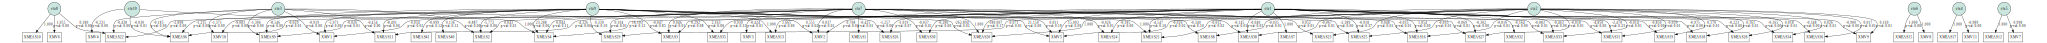

In [ ]:
g

In [ ]:
data

,y1,y2,y3,y4,y5,y6,y7,y8,x1,x2,x3
1,2.50,0.000000,3.333333,0.000000,1.250000,0.000000,3.726360,3.333333,4.442651,3.637586,2.557615
2,1.25,0.000000,3.333333,0.000000,6.250000,1.100000,6.666666,0.736999,5.384495,5.062595,3.568079
3,7.50,8.800000,9.999998,9.199991,8.750000,8.094061,9.999998,8.211809,5.961005,6.255750,5.224433
4,8.90,8.800000,9.999998,9.199991,8.907948,8.127979,9.999998,4.615086,6.285998,7.567863,6.267495
5,10.00,3.333333,9.999998,6.666666,7.500000,3.333333,9.999998,6.666666,5.863631,6.818924,4.573679
...,...,...,...,...,...,...,...,...,...,...,...
71,5.40,9.999998,6.666666,3.333333,3.750000,6.666666,6.666666,1.485166,4.477337,3.091042,1.987909
72,7.50,8.800000,9.999998,6.066666,7.500000,6.666666,9.999998,6.666666,5.337538,5.631212,3.491004
73,7.50,7.000000,9.999998,6.852998,7.500000,6.348340,6.666666,7.508044,6.129050,6.403574,5.001796
74,10.00,6.666666,9.999998,10.000000,10.000000,6.666666,9.999998,10.000000,5.003946,4.962845,3.976994


In [ ]:
from semopy.examples import political_democracy
from semopy import ModelMeans

desc = political_democracy.get_model()
data = political_democracy.get_data()
model = ModelMeans(desc)
model.fit(data)
semopy.report(model, "Political Democracy")

In [ ]:
from semopy import model_generation

In [ ]:
model_generation.generate_desc()

In [ ]:
semopy.calc_stats(mod)

,DoF,DoF Baseline,chi2,chi2 p-value,chi2 Baseline,CFI,GFI,AGFI,NFI,TLI,RMSEA,AIC,BIC,LogLik
Value,979,1128,51684.917084,0.0,463930.048345,0.890437,0.888593,0.871638,0.888593,0.873762,0.071971,383.663017,1804.10007,5.168492
